In [ ]:
#pip install -U bertopic
#pip install -U safetensors

#!pip install scikit-learn

In [ ]:
from bertopic import BERTopic
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

#load the model
topic_model = BERTopic.load("MaartenGr/BERTopic_Wikipedia")


In [27]:
#load the data 
test_data = pd.read_csv('dataset_germany.csv')

In [ ]:
# create embeddings, uses multilingual transformer (works with all languages we need)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)



In [ ]:
# cleaning the data a bit

test = test_data["comment_body"].dropna().astype(str).tolist()
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) \
             .union(stopwords.words('german')) \
             .union(stopwords.words('french')) \
             .union(stopwords.words('italian'))

def preprocess(test):
    test = test.lower()
    test = test.translate(str.maketrans('', '', string.punctuation))
    return " ".join([word for word in test.split() if word not in stop_words])

test_clean = [preprocess(doc) for doc in test]

In [ ]:
# running topic modelling + reducing number of topics, can change the number 
topics, probs = topic_model.fit_transform(test_clean)
topic_model.reduce_topics(test_clean, nr_topics=20)
new_topics, new_probs = topic_model.transform(test_clean)

In [ ]:
# check the output
print(topic_model.get_topic_info())

In [ ]:
# check just the topic and keywords for each 
for topic_num in range(0, 20):
    words = [word for word, _ in topic_model.get_topic(topic_num)]
    print(f"Topic {topic_num} - {', '.join(words)}")

In [ ]:
# add the results to dataset 
filtered_data = test_data.loc[test_data["comment_body"].notna()].copy()
filtered_data["comment_body_clean"] = test_clean 
filtered_data["topic"] = new_topics
filtered_data["topic_prob"] = new_probs 

In [ ]:
print(filtered_data)

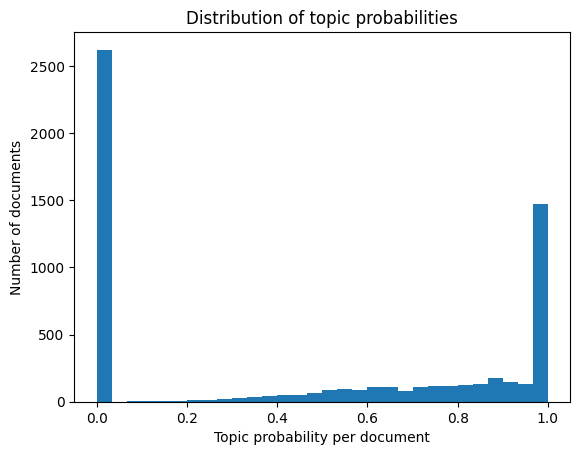

In [59]:

# check probs for each topic
plt.hist(new_probs, bins=30)
plt.xlabel('Topic probability per document')
plt.ylabel('Number of documents')
plt.title('Distribution of topic probabilities')
plt.show()

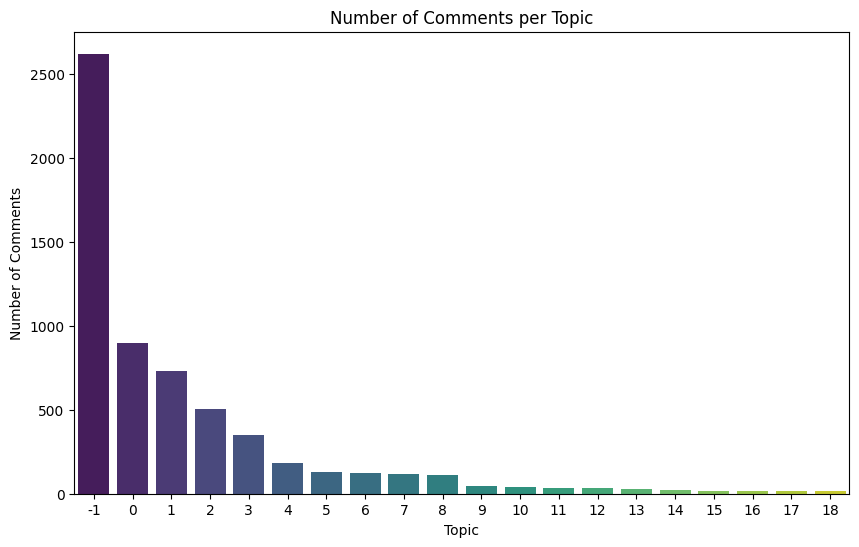

In [62]:

# count n comments per topic
topic_counts = filtered_data['topic'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.xlabel('Topic')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per Topic')
plt.show()

In [ ]:
#whats left to do
#1) how to assign general names for the topic? human readable
#2) how to visualize it?
#3) some stats on upvotes for each topic?
#4) which topics are noice? get rid of them?
#5) check against temperature in the day of the post?

Batches:   0%|          | 0/189 [00:00<?, ?it/s]

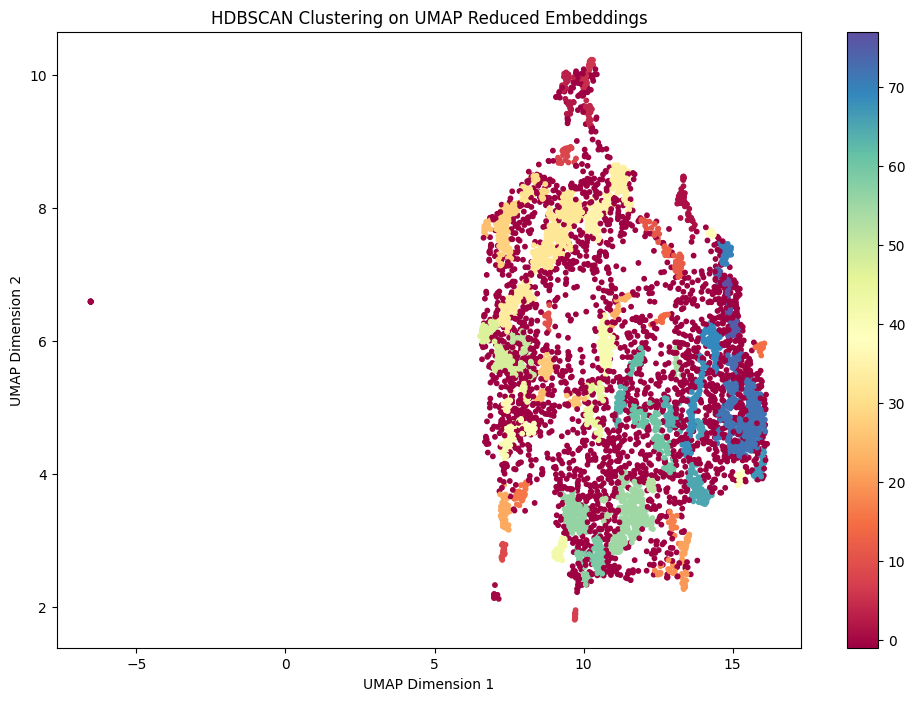

In [73]:
#smth from chatgpt, doesn't work yet


import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer

# Step 1: Get embeddings for your documents (if you don't already have them)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = embedding_model.encode(test_clean, show_progress_bar=True)

# Step 2: Reduce dimensionality to 2D with UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Step 3: Cluster with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(umap_embeddings)

# Step 4: Plot the clusters
plt.figure(figsize=(12,8))
scatter = plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=cluster_labels, cmap='Spectral', s=10)
plt.colorbar(scatter)
plt.title("HDBSCAN Clustering on UMAP Reduced Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()